In [8]:
# Imports
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Constants
NSHARDS = 10
MODELS = ['MLP', 'GCN', 'HGCN']

In [4]:
def df_gen(RESULTS_DIR, NSHARDS):  
  dfs = []
  for shard_idx in range(NSHARDS):
    filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
    print(filename)

    with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
      lines = f.readlines()
      records = map(json.loads, lines)
      dfs.append(pd.DataFrame.from_records(records))

  # Construct df and remove nans
  results_df = pd.concat(dfs)
  results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
  # results_df.dropna(axis=0, inplace=True)
  del dfs
  return results_df

In [5]:
def plot_gen(df, METRIC):
	plt.scatter(df["MLP__" + METRIC], df["GCN__" + METRIC], s=5)
	plt.plot([0, 1], [0, 1], color='red', linestyle='--')
	plt.title(f'Performance comparison between GCN and MLP')
	plt.xlabel(f'{"GCN__" + METRIC}')
	plt.ylabel(f'{"MLP__" + METRIC}')
	plt.legend(fontsize='small')
	plt.tight_layout()
	plt.show()
	
	cluster_sizes = df['num_clusters'].unique()
	fig, axes = plt.subplots(2, 4, figsize=(12, 6))
	axes = axes.flatten()
	for cluster_size in np.sort(cluster_sizes):
		axes_index = cluster_size - cluster_sizes.min()
		df_2_clusters = df[df['num_clusters'] == cluster_size]
		MLP_better = df_2_clusters["MLP__" + METRIC] > df_2_clusters["GCN__" + METRIC]+.05
		GCN_better = df_2_clusters["GCN__" + METRIC] > df_2_clusters["MLP__" + METRIC]+.05
		total_samples = len(MLP_better)

		ax = axes[axes_index]
		ax.scatter(df_2_clusters["GCN__" + METRIC][MLP_better],
				df_2_clusters["MLP__" + METRIC][MLP_better], color = 'orange', s = 5)
		ax.scatter(df_2_clusters["GCN__" + METRIC][GCN_better],
				df_2_clusters["MLP__" + METRIC][GCN_better], color = 'green', s = 5)
		ax.scatter(df_2_clusters["GCN__" + METRIC][~(MLP_better | GCN_better)],
				df_2_clusters["MLP__" + METRIC][~(MLP_better | GCN_better)], s = 5)
		ax.plot([0, 1], [0, 1], color='red', linestyle='--')
		ax.scatter([], [], label=f"MLP better: {sum(MLP_better)}", color = 'orange')
		ax.scatter([], [], label=f"GCN better: {sum(GCN_better)}", color = 'green')
		ax.set_title(f'Number of classes: {cluster_size}')
		ax.set_xlabel(f'{"GCN__" + METRIC}')
		ax.set_ylabel(f'{"MLP__" + METRIC}')
		ax.legend(fontsize='small')

	# Hide unused subplots if cluster_sizes < 8
	for i in range(len(cluster_sizes), len(axes)):
		axes[i].axis('off')

	plt.suptitle("Performance comparison between GCN and MLP as number of classes increases")
	plt.tight_layout()
	plt.show()

	cluster_sizes = df['num_clusters'].unique()
	_, axes = plt.subplots(2, 4, figsize=(12, 6))
	axes = axes.flatten()
	for cluster_size in np.sort(cluster_sizes):
		axes_index = cluster_size - cluster_sizes.min()
		df_2_clusters = df[df['num_clusters'] == cluster_size]
		small_mask = df_2_clusters['nvertex'] < 2000
		mid_mask = (df_2_clusters['nvertex'] >= 2000) & (df_2_clusters['nvertex'] < 3000)
		large_mask = df_2_clusters['nvertex'] >= 3000
		ax = axes[axes_index]
		ax.scatter(df_2_clusters["MLP__" + METRIC][small_mask], df_2_clusters["GCN__" + METRIC][small_mask], s=10, color = 'green', label = '1000-2000')
		ax.scatter(df_2_clusters["MLP__" + METRIC][mid_mask], df_2_clusters["GCN__" + METRIC][mid_mask], s=10, color = 'orange', label = '2000-3000')    
		ax.scatter(df_2_clusters["MLP__" + METRIC][large_mask], df_2_clusters["GCN__" + METRIC][large_mask], s=10, color = 'red', label = '3000-4000')
		ax.set_title(f'Number of classes: {cluster_size}')
		ax.set_xlabel(f'{"MLP__" + METRIC}')
		ax.set_ylabel(f'{"GCN__" + METRIC}')
		ax.legend(fontsize='small')

	# Hide unused subplots if cluster_sizes < 8
	for i in range(len(cluster_sizes), len(axes)):
		axes[i].axis('off')

	plt.suptitle("Performance comparison between GCN and MLP based on graph size, stratified across number of classes")
	plt.tight_layout()
	plt.show()


	models = ['MLP', 'GCN', 'HGCN']

	plt.figure(figsize=(10, 6))

	for model in models:
		grouped = df.groupby('num_clusters')[f'{model}__test_accuracy']
		means = grouped.mean()
		stds = grouped.std()

		plt.errorbar(
			means.index, means.values, yerr=stds.values, fmt='o-', capsize=5, label=model
		)

	# Add random guessing baseline
	cluster_sizes = sorted(df['num_clusters'].unique())
	random_guess = [1 / c for c in cluster_sizes]
	plt.plot(cluster_sizes, random_guess, 'k--', label='Random Guessing')

	plt.xlabel('Number of Clusters')
	plt.ylabel('Accuracy')
	plt.title('Model Accuracy vs. Number of Clusters (mean ± std)')
	plt.grid(True)
	plt.legend()
	plt.tight_layout()
	plt.show()

In [ ]:
RESULTS_DIR_random_gs = '../../graph_gen/snellius_gen/random_gs/random_gs'
results_df_random_gs = df_gen(RESULTS_DIR_random_gs, NSHARDS)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [52]:
smaller_graphs_df = df_gen("../../graph_gen/snellius_gen/smaller_graphs/smaller_graphs/", NSHARDS)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_18404/3165775925.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize='small')


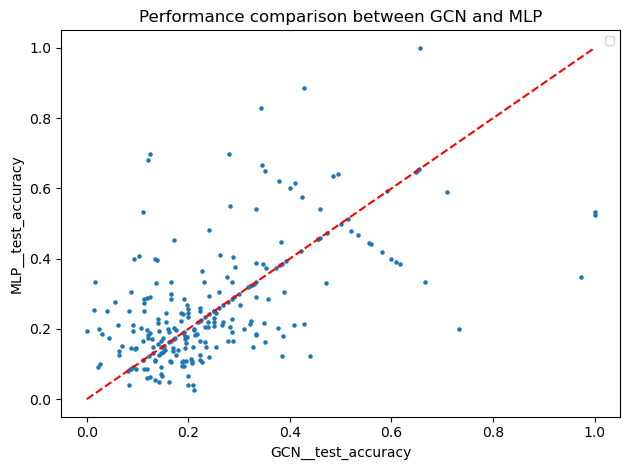

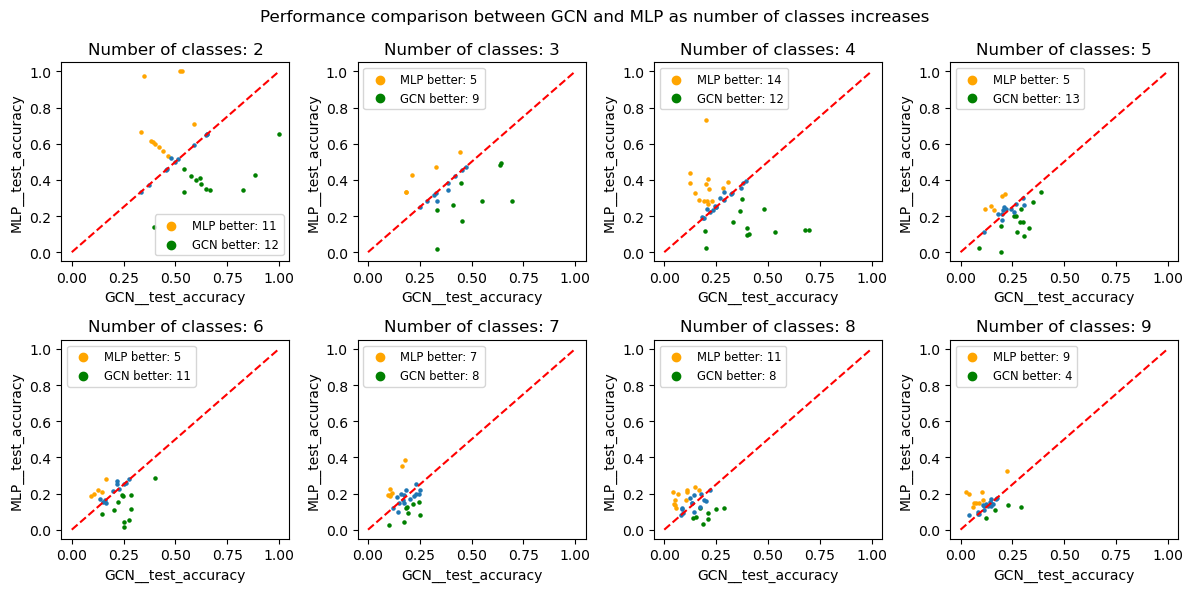

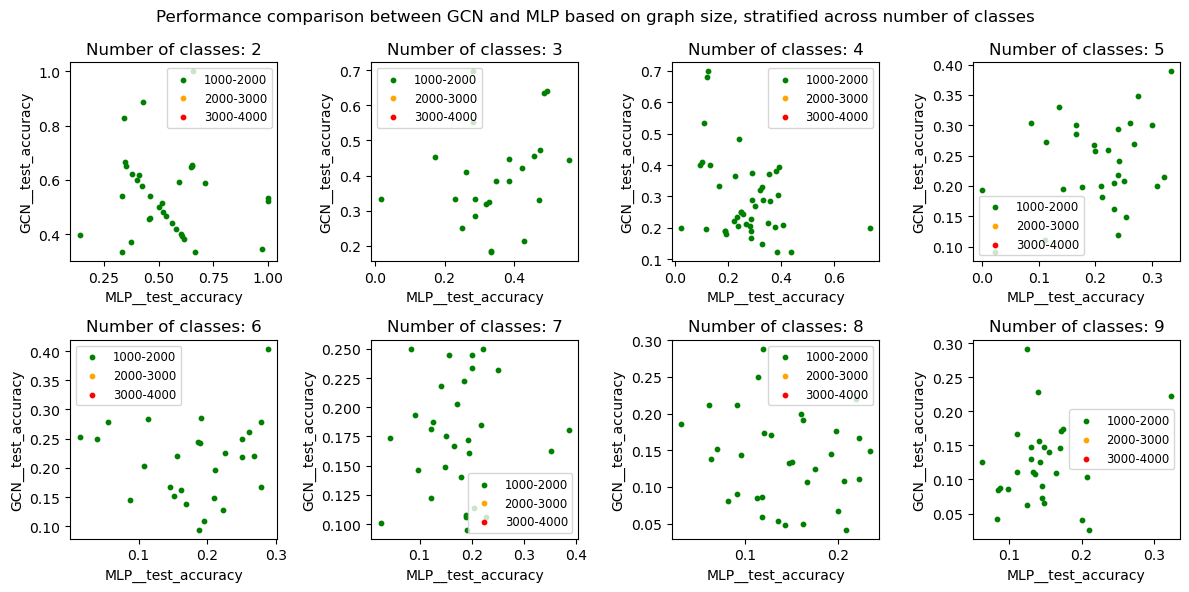

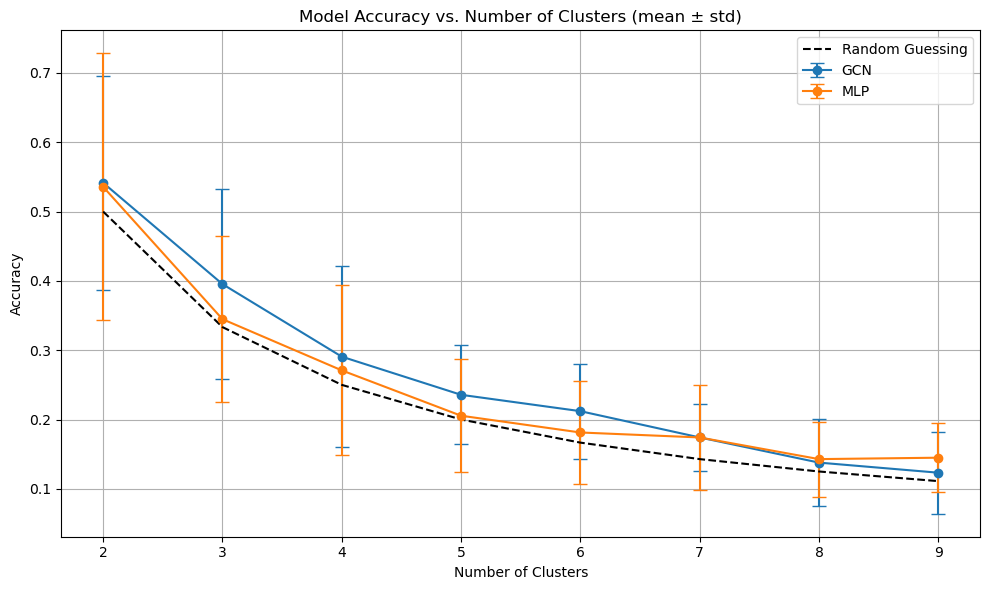

In [63]:
plot_gen(smaller_graphs_df, "test_accuracy")

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_18404/3165775925.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize='small')


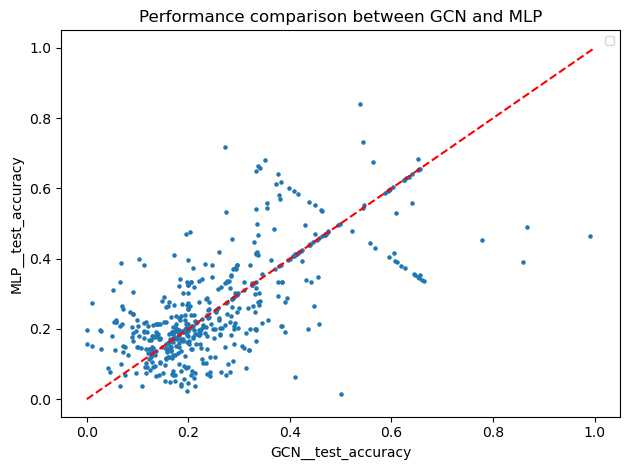

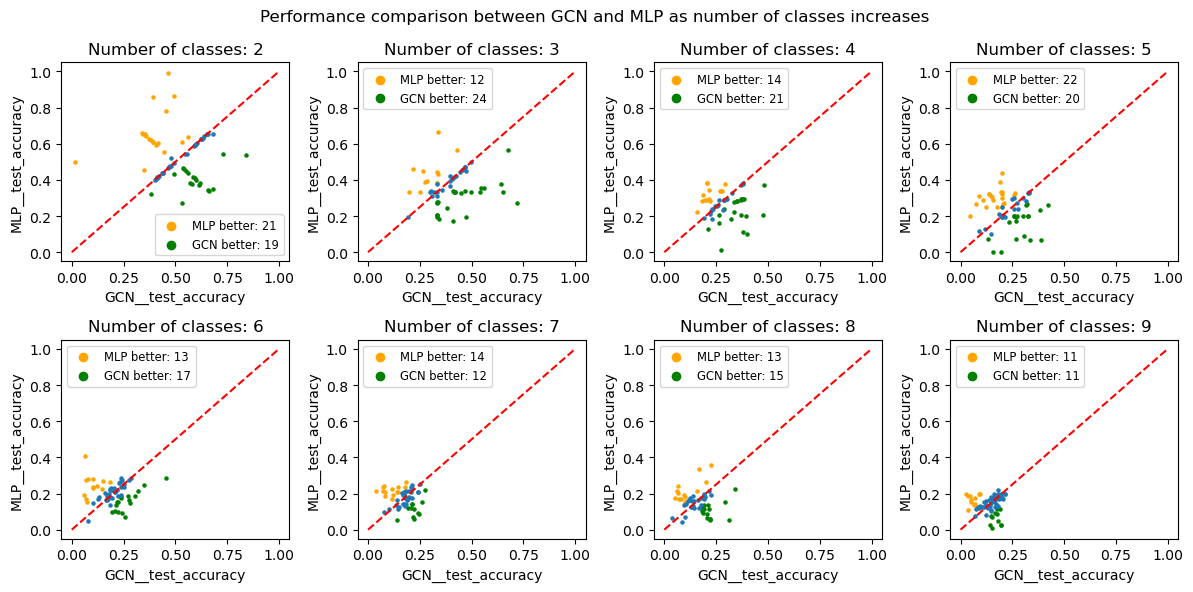

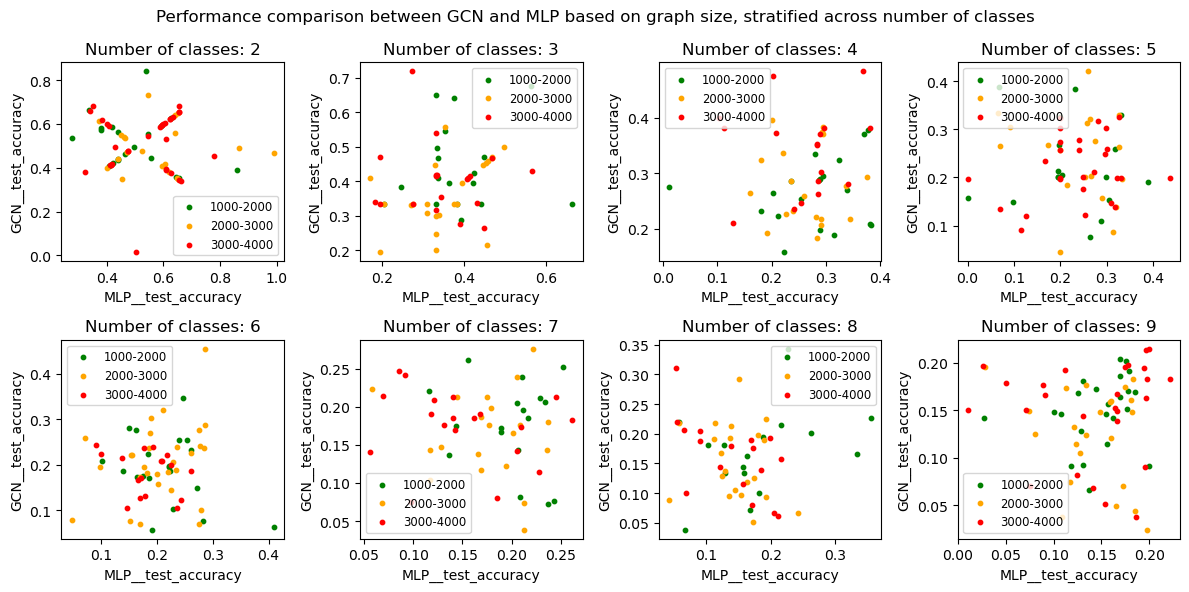

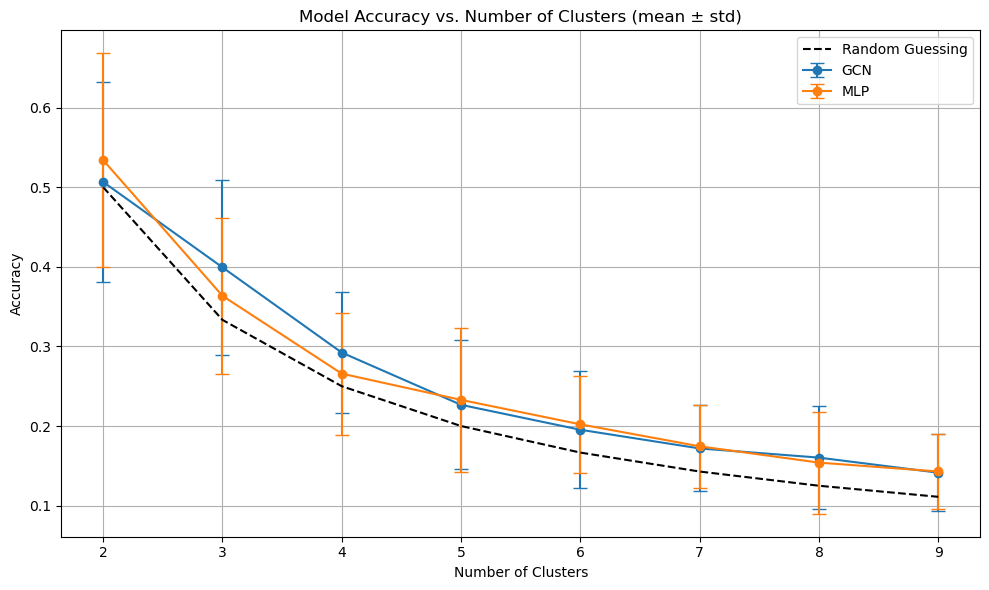

In [65]:
main_snellius_gen_link = "../../graph_gen/snellius_gen/nodeclassification/sbm/"
main_snellius_df = df_gen(main_snellius_gen_link, NSHARDS)
plot_gen(main_snellius_df, "test_accuracy")

## Varied feature dim investigations

In [114]:
RESULTS_DIR = '../../graph_gen/snellius_gen/vary_dim/'
two_df = df_gen(RESULTS_DIR= RESULTS_DIR + '2', NSHARDS = NSHARDS)
eight_df = df_gen(RESULTS_DIR= RESULTS_DIR + '8', NSHARDS = NSHARDS)
sixteen_df = df_gen(RESULTS_DIR= RESULTS_DIR + '16', NSHARDS = NSHARDS)
cts_hyp_df = df_gen(RESULTS_DIR=RESULTS_DIR + 'cts_hyp', NSHARDS=NSHARDS)


results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

def boxplot_metric_by_feature_dim(combined_df, models, metric, figsize=(8, 6)):
    """
    Create a boxplot of <model>__<metric> grouped by feature_dim, 
    for each model in `models`.
    
    Args:
        combined_df: DataFrame containing all feature_dim batches plus results.
        models: list of model prefixes, e.g. ['GCN', 'MLP', 'HGCN']
        metric: the performance metric suffix, e.g. 'test_accuracy'
        figsize: figure size tuple
    """
    colnames = [f"{m}__{metric}" for m in models]
    combined_df.boxplot(
        column=colnames,
        by='feature_dim',
        grid=True,
        patch_artist=False,
        boxprops=dict(color='orange'),
        medianprops=dict(color='red')
    )
    plt.suptitle('') 
    plt.title('')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.xlabel('Feature Dimension')
    plt.show()


def scatter_model_vs_model_given_dim(combined_df, model_x, model_y, metric, dim, cmap='viridis', figsize=(6, 6)):
    """
    Scatter plot of model_x vs model_y on <metric>, colored by feature_dim.
    
    Args:
        combined_df: the combined DataFrame.
        model_x: prefix string for X model, e.g. 'GCN'
        model_y: prefix string for Y model, e.g. 'HGCN'
        metric: performance metric suffix, e.g. 'test_accuracy'
        cmap: colormap for feature_dim
        figsize: size of figure
    """
    xcol = f"{model_x}__{metric}"
    ycol = f"{model_y}__{metric}"
    scatter = plt.scatter(
        combined_df[xcol][combined_df['feature_dim'] == dim],
        combined_df[ycol][combined_df['feature_dim'] == dim],
        cmap=cmap,
        alpha=0.7,
        edgecolors='w',
        s=60
    )

    plt.plot([combined_df[xcol][combined_df['feature_dim'] == dim].min(), combined_df[xcol][combined_df['feature_dim'] == dim].max()], 
             [combined_df[xcol][combined_df['feature_dim'] == dim].min(), combined_df[xcol][combined_df['feature_dim'] == dim].max()], 
             'r--', linewidth=1)
    # cbar = plt.colorbar(scatter)
    # cbar.set_label('feature_dim')
    plt.xlabel(f"{model_x} {metric.replace('_', ' ').title()}")
    plt.ylabel(f"{model_y} {metric.replace('_', ' ').title()}")
    plt.title(f"{model_x} vs {model_y} ({metric.replace('_', ' ').title()}) and feature dim {dim}")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def boxplot_metric_vs_train_size(combined_df, model, metric, figsize=(8, 6)):
    """
    Boxplot of <model>__<metric> vs num_train_per_class, with hue=feature_dim.
    
    Args:
        combined_df: the combined DataFrame
        model: model prefix, e.g. 'HGCN'
        metric: performance metric suffix, e.g. 'test_accuracy'
        figsize: size of figure
    """
    colname = f"{model}__{metric}"
    plt.figure(figsize=figsize)
    sns.boxplot(
        x='num_train_per_class',
        y=colname,
        hue='feature_dim',
        data=combined_df,
        palette='magma'
    )
    plt.title(f"{model} {metric.replace('_', ' ').title()} vs Num Train per Class")
    plt.xlabel('Num Train per Class')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend(title='feature_dim')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_performance_vs_clusters(combined_df, model, metric):
    """
    Plots the average performance (given by `model__metric`) 
    versus number of ground‐truth clusters, for each feature_dim.
    Also includes a random‐guessing baseline (accuracy = 1/num_clusters).

    Args:
      combined_df: DataFrame containing at least these columns:
                   - 'feature_dim'
                   - 'num_clusters'
                   - f"{model}__{metric}"  (e.g. "HGCN__test_accuracy")
      model:       String prefix of the model, e.g. 'GCN', 'MLP', or 'HGCN'.
      metric:      String suffix of the performance metric, e.g. 'test_accuracy'.
    """
    colname = f"{model}__{metric}"
    # Drop any rows where the required columns are missing
    df = combined_df[['feature_dim', 'num_clusters', colname]].dropna()

    # Compute mean performance per (feature_dim, num_clusters)
    grouped = (
        df
        .groupby(['feature_dim', 'num_clusters'])[colname]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(8, 6))
    for dim in sorted(grouped['feature_dim'].unique()):
        sub = grouped[grouped['feature_dim'] == dim]
        plt.plot(
            sub['num_clusters'],
            sub[colname],
            marker='o',
            label=f"{model}, feat_dim={dim}"
        )

    # Random‐guessing baseline: accuracy = 1/num_clusters
    all_clusters = sorted(df['num_clusters'].unique())
    random_baseline = [1.0 / k for k in all_clusters]
    plt.plot(
        all_clusters,
        random_baseline,
        'k--',
        linewidth=1.5,
        label="Random Guessing"
    )

    plt.xlabel("Number of Clusters (num_clusters)")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"{model} {metric.replace('_', ' ').title()} vs Number of Clusters")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_models_vs_clusters_for_dim(combined_df, feature_dim, models, metric):
    """
    For a fixed feature_dim, plot each model's average performance (model__metric)
    versus number of ground‐truth clusters, all on the same axes, plus a random baseline.

    Args:
      combined_df: DataFrame containing ['feature_dim', 'num_clusters',
                    f"{model}__{metric}" for each model in `models`].
      feature_dim: Integer, the specific feature_dim to filter on (e.g. 2, 8, 16).
      models:      List of model prefixes, e.g. ['GCN', 'MLP', 'HGCN'].
      metric:      Performance metric suffix, e.g. 'test_accuracy' or 'test_f1_macro'.
    """
    # Filter to only rows with the specified feature_dim
    df = combined_df[combined_df['feature_dim'] == feature_dim]
    # Keep only num_clusters and each model__metric column
    keep_cols = ['num_clusters'] + [f"{m}__{metric}" for m in models]
    df = df[keep_cols].dropna()

    # Group by num_clusters and compute the mean for each model's metric
    grouped = df.groupby('num_clusters').mean().reset_index()

    plt.figure(figsize=(8, 6))
    for model in models:
        colname = f"{model}__{metric}"
        plt.plot(
            grouped['num_clusters'],
            grouped[colname],
            marker='o',
            label=model
        )

    # Add random‐guessing baseline: accuracy = 1/num_clusters
    num_clusters = grouped['num_clusters'].values
    random_baseline = 1.0 / num_clusters
    plt.plot(
        num_clusters,
        random_baseline,
        'k--',
        linewidth=1.5,
        label="Random Guessing"
    )

    plt.xlabel("Number of Clusters (num_clusters)")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"Models' {metric.replace('_', ' ').title()} vs Number of Clusters\n(feature_dim = {feature_dim})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def boxplot_models_vs_clusters_for_dim(combined_df, feature_dim, models, metric, figsize=(8,6)):
    """
    For a fixed feature_dim, draw a grouped boxplot of each model’s performance (model__metric)
    versus num_clusters. No interpolation—just one box per model at each cluster size.

    Args:
      combined_df: DataFrame containing at least:
                   - 'feature_dim'
                   - 'num_clusters'
                   - f"{model}__{metric}" for each model in `models`
      feature_dim: Integer, the specific feature_dim to filter on (e.g. 2, 8, 16).
      models:      List of model prefixes, e.g. ['GCN', 'MLP', 'HGCN'].
      metric:      Performance metric suffix, e.g. 'test_accuracy' or 'test_f1_macro'.
      figsize:     Tuple for figure size (default (8,6)).
    """
    # Filter to the specified feature_dim
    df = combined_df[combined_df['feature_dim'] == feature_dim].copy()
    # Keep only num_clusters and each model__metric column, then drop NaNs
    keep_cols = ['num_clusters'] + [f"{m}__{metric}" for m in models]
    df = df[keep_cols].dropna()

    # Melt into long form: columns = ['num_clusters', 'model', 'performance']
    long_df = pd.melt(
        df,
        id_vars=['num_clusters'],
        value_vars=[f"{m}__{metric}" for m in models],
        var_name='model',
        value_name='performance'
    )
    # Strip off the "__<metric>" suffix so 'model' is just 'GCN', 'MLP', etc.
    long_df['model'] = long_df['model'].str.replace(f"__{metric}", "", regex=False)

    # Draw grouped boxplot
    plt.figure(figsize=figsize)
    sns.boxplot(
        x='num_clusters',
        y='performance',
        hue='model',
        data=long_df,
        palette='Set2'
    )

    plt.xlabel("Number of Clusters")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"Feature Dim = {feature_dim}: {metric.replace('_', ' ').title()} vs Num Clusters\n(Boxplot per model)")
    plt.legend(title='Model', loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_all_models_regression_for_dim(combined_df, feature_dim, metric, x_col, ci=95):
    """
    For a fixed feature_dim, fit and plot a separate linear regression for each of three models
    (GCN, MLP, HGCN) vs x_col, all in the same axes, with confidence intervals.

    Args:
      combined_df: DataFrame containing at least these columns:
                   - 'feature_dim'
                   - x_col (e.g. 'avg_degree', 'feature_angular_snr', etc.)
                   - 'GCN__<metric>', 'MLP__<metric>', 'HGCN__<metric>'
      feature_dim: The single feature_dim value to filter (e.g. 2, 8, or 16).
      metric:      Metric suffix (e.g. 'test_accuracy' or 'test_f1_macro').
      x_col:       The independent variable column name (e.g. 'avg_degree').
      ci:          Confidence‐interval percentage for the regression lines.
    """
    # Build column names
    col_gcn  = f"GCN__{metric}"
    col_mlp  = f"MLP__{metric}"
    col_hgcn = f"HGCN__{metric}"

    # Filter to the specified feature_dim
    df = combined_df[combined_df['feature_dim'] == feature_dim].copy()
    df = df[[x_col, col_gcn, col_mlp, col_hgcn]].dropna()

    # Melt into long form: columns = [x_col, 'model', 'value']
    long_df = pd.melt(
        df,
        id_vars=[x_col],
        value_vars=[col_gcn, col_mlp, col_hgcn],
        var_name='model',
        value_name='performance'
    )
    # Simplify model names
    long_df['model'] = long_df['model'].str.replace(f"__{metric}", "")

    # Use seaborn's lmplot with hue='model' to overlay three regression lines
    sns.lmplot(
        data=long_df,
        x=x_col,
        y='performance',
        hue='model',
        ci=ci,
        markers=['o', 's', 'D'],
        palette='tab10',
        height=6,
        aspect=1.2,
        scatter=False
    )
    plt.xlabel(x_col.replace('_', ' ').title())
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(
        f"Regression of GCN / MLP / HGCN vs {x_col.replace('_', ' ').title()}\n"
        f"(feature_dim = {feature_dim})"
    )
    plt.tight_layout()
    plt.show()

def compute_and_plot_graph_metric_correlations(
    df: pd.DataFrame,
    feature_dim: int,
    graph_metrics: list,
    models: list,
    perf_suffix: str = "test_f1_macro",
    corr_method: str = "pearson",
    figsize: tuple = (10, 8)
):
    """
    1) Filters df to rows where 'feature_dim' == feature_dim.
    2) For each graph‐metric in graph_metrics, compute its correlation (Pearson or Spearman)
       against each model’s performance column: f"{model}__{perf_suffix}".
    3) Plots the resulting correlation matrix as a heatmap.

    Args:
      df:            The full DataFrame containing your results and graph_metrics.
      feature_dim:   Integer (e.g. 16), to filter on df['feature_dim'] == feature_dim.
      graph_metrics: List of column‐names (strings) that describe graph‐level metrics.
      models:        List of model‐prefixes, e.g. ['MLP','GCN','HGCN'].
      perf_suffix:   The suffix of the performance column, e.g. "test_f1_macro".
      corr_method:   "pearson" or "spearman".
      figsize:       Size of the final figure.
    Returns:
      corr_df:       A DataFrame of shape (len(graph_metrics) × len(models)), containing
                     correlation coefficients.
    """

    # 1) Filter to feature_dim == 16
    df16 = df[df["feature_dim"] == feature_dim].copy()
    if df16.shape[0] == 0:
        raise ValueError(f"No rows with feature_dim == {feature_dim} found.")

    # 2) Build an empty DataFrame to hold correlation coefficients
    corr_df = pd.DataFrame(
        index=graph_metrics,
        columns=models,
        dtype=float
    )

    # 3) For each model, for each graph_metric, compute correlation w.r.t. performance
    for model in models:
        perf_col = f"{model}__{perf_suffix}"
        if perf_col not in df16.columns:
            raise KeyError(f"Performance column {perf_col} not found in DataFrame.")

        # We’ll drop NaNs pairwise
        for metric in graph_metrics:
            if metric not in df16.columns:
                raise KeyError(f"Graph‐metric column {metric} not found in DataFrame.")
            sub = df16[[metric, perf_col]].dropna()

            # Now drop any rows where either value is not finite (inf or NaN).
            # (pearsonr / spearmanr require strictly finite inputs.)
            x = sub[metric].values
            y = sub[perf_col].values
            finite_mask = np.isfinite(x) & np.isfinite(y)
            x_finite = x[finite_mask]
            y_finite = y[finite_mask]

            # If fewer than 3 points remain, correlation is not well-defined:
            if x_finite.shape[0] < 3:
                corr_val = np.nan
            else:
                if corr_method == "pearson":
                    corr_val, _ = pearsonr(x_finite, y_finite)
                elif corr_method == "spearman":
                    corr_val, _ = spearmanr(x_finite, y_finite)
                else:
                    raise ValueError("corr_method must be 'pearson' or 'spearman'.")

            corr_df.loc[metric, model] = corr_val

    # 4) Plot a heatmap of those correlation coefficients
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_df.astype(float),
        annot=True,
        fmt=".2f",
        cmap="RdBu_r",
        center=0.0,
        cbar_kws={"label": f"{corr_method.title()} correlation"}
    )
    plt.title(f"{corr_method.title()} correlations (feature_dim={feature_dim})")
    plt.ylabel("Graph‐level metric")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return corr_df

def scatter_with_reg_line(
    df: pd.DataFrame,
    feature_dim: int,
    x_col: str,
    model: str,
    perf_suffix: str = "test_f1_macro",
    corr_method: str = "pearson",
    figsize: tuple = (6,4)
):
    """
    Draw a scatterplot (noisy points) of x_col vs. {model}__{perf_suffix},
    restricted to feature_dim, plus a fitted regression line (and CI envelope).
    Also prints the numeric correlation coefficient on top.
    """
    # Filter
    df16 = df[df["feature_dim"] == feature_dim].copy()
    perf_col = f"{model}__{perf_suffix}"
    sub = df16[[x_col, perf_col]].dropna()
    if sub.shape[0] < 3:
        print("Not enough points to plot or compute correlation.")
        return

    # Compute correlation
    x = sub[x_col].values
    y = sub[perf_col].values
    if corr_method == "pearson":
        r, pval = pearsonr(x, y)
        corr_label = f"Pearson r = {r:.2f}, p = {pval:.3g}"
    else:
        r, pval = spearmanr(x, y)
        corr_label = f"Spearman ρ = {r:.2f}, p = {pval:.3g}"

    # Plot
    plt.figure(figsize=figsize)
    sns.regplot(
        x=x_col,
        y=perf_col,
        data=sub,
        scatter_kws={"alpha": 0.4},
        ci=95,
        line_kws={"color": "red"},
        scatter=True
    )
    plt.title(f"{model} – {perf_suffix} vs. {x_col} (dim={feature_dim})\n{corr_label}")
    plt.xlabel(x_col.replace("_", " ").title())
    plt.ylabel(f"{model} {perf_suffix.replace('_',' ').title()}")
    plt.tight_layout()
    plt.show()
    import pandas as pd

def smoothed_plot_perf_vs_metric(
    df: pd.DataFrame,
    models: list[str],
    perf_meas: str,
    metric: str,
    n_bins: int = 10,
    figsize: tuple[int, int] = (8, 5),
    cmap: str = 'tab10'
):
    """
    Plot smoothed binned performance vs. metric for multiple models,
    with shaded 95% confidence intervals around the mean.

    Parameters
    ----------
    df : DataFrame
        Must contain the column [metric] and, for each model in `models`,
        a performance column named model+perf_meas (e.g. 'GCN'+'accuracy' → 'GCNaccuracy').
    models : list of str
        Model-name prefixes.
    perf_meas : str
        Performance-measure suffix (e.g. 'f1_macro', 'accuracy').
    metric : str
        The continuous metric to bin (e.g. 'homophily_rate').
    n_bins : int, default=10
        Number of equal-width bins to split the metric into.
    figsize : (width, height)
        Figure size.
    cmap : str
        Matplotlib colormap for the model curves.
    """
    # 1. Create equal-width bins and label them by their center values
    bin_edges = np.linspace(df[metric].min(), df[metric].max(), n_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)

    # 2. Initialize plot
    plt.figure(figsize=figsize)
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(models)))

    # 3. For each model, compute mean and 95% CI in each bin and plot
    for model, color in zip(models, colors):
        col = f"{model}__{perf_meas}"
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame.")

        grp = df.groupby('_bin')[col]
        count = grp.count()                    # number of observations per bin
        mean = grp.mean()                      # mean performance per bin
        std  = grp.std(ddof=1)                 # sample standard deviation
        sem  = std / np.sqrt(count)            # standard error of the mean
        ci95 = 1.96 * sem                      

        # Only keep bins with data
        valid = count > 0
        x     = mean.index.astype(float)[valid]
        y     = mean[valid]
        lower = y - ci95[valid]
        upper = y + ci95[valid]

        # Plot mean line and shaded 95% CI
        plt.plot(x, y, label=model, color=color, linewidth=2)
        plt.fill_between(x, lower, upper, color=color, alpha=0.3)

    # 4. Final styling
    plt.xlabel(metric)
    plt.ylabel(perf_meas)
    plt.title(f"{perf_meas} vs {metric} (binned, with 95% CI)")
    plt.legend(title="Model")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Clean up temporary column
    df.drop(columns=['_bin'], inplace=True)


## Experimental details

We used the SBM random graph model, with the graph generational parameters varied as seen below:

| Parameter name           | Description                                                                 | Range        |
|--------------------------|-----------------------------------------------------------------------------|--------------|
| nvertex                  | Number of nodes in the graph                                                | [128, 1024]  |
| avg_degree              | Target average node degree                                                  | [2.0, 16.0]  |
| feature_center_distance | Distance between class-specific feature centers                             | [0.0, 2.0]   |
| feature_dim             | Dimensionality of the node feature vectors                                  | {2,8,16}        |
| p_to_q_ratio            | Ratio of intra-cluster to inter-cluster edge probabilities (p/q)            | [1.0, 8.0]   |
| num_clusters            | Number of clusters/classes in the graph                                     | [2.0, 9.0]   |
| cluster_size_slope      | Slope of the linear cluster size distribution (0 = equal sized clusters)    | [0.0, 1.0]   |
| power_exponent          | Exponent of the power-law degree distribution (if enabled)                  | [0.2, 0.9]   |
| min_deg                 | Minimum allowed node degree                                                 | [2]          |

We wanted to, amongst other things, clarify the influence feature dimension had on model performance. We evaluated three models: a MLP, a GCN and a HGCN. For each choice of feature_dim, 500 graphs were generated. The aforementioned GNNs were then benchmarked on these graphs. Each model was benchmarked following the same training and model hyperparameter optimization procedure. In particular, we limited the models to 6 training examples per class and 50 validation nodes sampled proportionality according to the class size distribution. Hyperparameters were optimized using TPE, a Bayesian hyperparameter search method. For each model, the following hyperparamters were searched over:

| Hyperparameter   | Description                                                     | Range/Values              |
|------------------|-----------------------------------------------------------------|---------------------------|
| IN_CHANNELS      | Dimensionality of input node features                           | [16]                      |
| LR               | Learning rate                                                   | [5e-4, 1e-3, 2e-3]         |
| HIDDEN_CHANNELS  | Number of hidden units per layer                                | [8, 16, 32]               |
| NUM_LAYERS       | Number of message-passing layers                                | [1, 2, 3]                 |
| DROPOUT          | Dropout rate applied after each layer                           | [0.0, 0.2, 0.4, 0.6]      |
| EPOCHS           | Maximum number of training epochs                               | [200]                     |
| WEIGHT_DECAY     | L2 regularization strength                                       | [0.0, 1e-4, 5e-4, 1e-3]   |
| PATIENCE         | Early stopping patience (in epochs without improvement)         | [10]                      |
| C                | Curvature of the hyperbolic space (HGCN only; `None` = Euclidean) | [None, 0.5, 1.0, 2.0]     |

We experimented with continuous ranges of hyperparameters, for parameters like LR, DROPOUT and WEIGHT_DECAY, but found no consistent population-level increase in performance. 

## Results
Let's initially look at average model performance for a fixed feature dimension. 

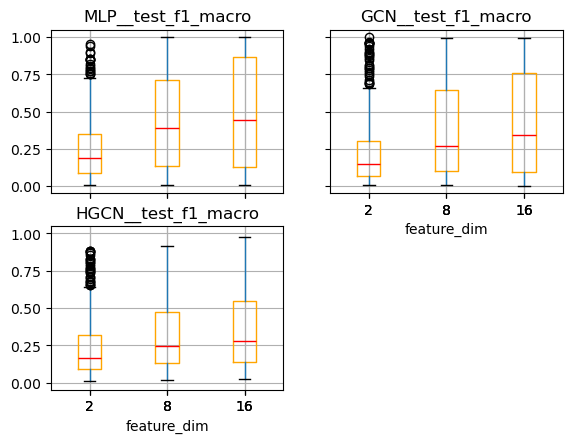


Dimension 2:
--------
MLP mean: 0.25, std: 0.21
GCN mean: 0.23, std: 0.21
HGCN mean: 0.23, std: 0.19

Dimension 8:
--------
MLP mean: 0.44, std: 0.30
GCN mean: 0.37, std: 0.30
HGCN mean: 0.32, std: 0.24

Dimension 16:
--------
MLP mean: 0.49, std: 0.36
GCN mean: 0.43, std: 0.34
HGCN mean: 0.36, std: 0.25


In [108]:
two_df['feature_dim']     = 2
eight_df['feature_dim']   = 8
sixteen_df['feature_dim'] = 16
combined_df = pd.concat([two_df, eight_df, sixteen_df], ignore_index=True)

# Step B: call any of the functions above. For example:
dims = [2,8,16]
models = ['MLP', 'GCN', 'HGCN']
metric = 'test_f1_macro'

# 1) Boxplot by feature_dim
boxplot_metric_by_feature_dim(combined_df, models, metric)
for dim in dims:
    print(f"\nDimension {dim}:\n--------")
    for model in models:
        mod_dim_per_df = combined_df[combined_df['feature_dim']==dim][f'{model}__{metric}']
        print(f'{model} mean: {mod_dim_per_df.mean():.2f}, std: {mod_dim_per_df.std():.2f}') 


All models struggle when feature dimension is 2. Performance is widely varied, with all models capable of performing well on outlier graphs, with the general spread of performance under .4 (see bar plots). Across dimensions, the standard deviation of all models increases. The relative order of performance is consistent across dimensions: MLP > GCN > HGCN. 

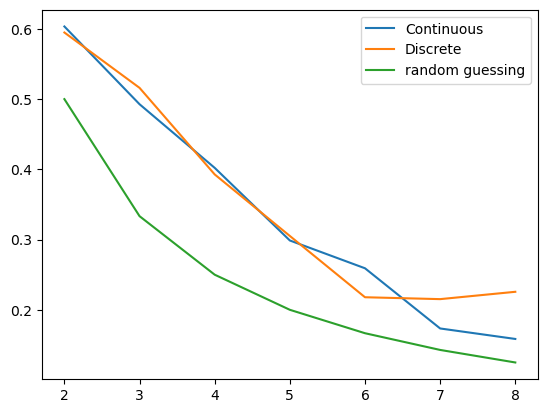

In [157]:
model = 'HGCN'

perf_cts = cts_hyp_df.groupby('num_clusters')[model + '__'+metric].mean()
perf_dis = sixteen_df.groupby('num_clusters')[model + '__' + metric].mean()
rand_guess = np.array([1/el for el in np.arange(2,9)])

plt.plot(perf_cts, label = 'Continuous')
plt.plot(perf_dis, label = 'Discrete')
plt.plot(np.arange(2,9), rand_guess, label = 'random guessing')
plt.legend()
plt.show()

We compute several metrics, pertaining to both the graph and the node-features. These are:

* **Edge homogeneity** → Fraction of edges whose endpoints share the same label (measures how assortative the graph is with respect to the true classes).

* **Avg in feature angular distance** → Average angular‐similarity among feature vectors of nodes within the same class (measures intra‐class feature cohesion).

* **Avg out feature angular distance** → Average angular‐similarity among feature vectors of nodes across different classes (measures inter‐class feature overlap).

* **Feature angular SNR** → Ratio of in‐class similarity to out‐of‐class similarity (high ⇒ features separate classes well).

* **Pareto exponent** → Fitted power‐law exponent of the positive degree sequence (low exponent ⇒ heavier‐tailed, hub-dominated degree distribution).

* **Avg degree est** → Mean node degree (measures overall graph sparsity/density).

* **Community size Simpsons** → Simpson index \$\sum\_i \pi\_i^2\$ over class sizes (high ⇒ very imbalanced class sizes) where \$\pi\_i\$ is probability that node is in class \$i\$.

* **P to Q ratio est** → (Observed within‐class edge density) / (observed between‐class edge density) using unweighted class proportions (measures edge‐based assortativity).

* **P to Q ratio est DC** → Same \$p/q\$ ratio but degree‐corrected (uses sum of degrees per class in the denominator).

* **Num clusters** → Number of distinct labels (i.e. ground-truth communities).

It is of interest to us how these correlate with model performance. Restricting to a node-feature dimension of 16, we observe:


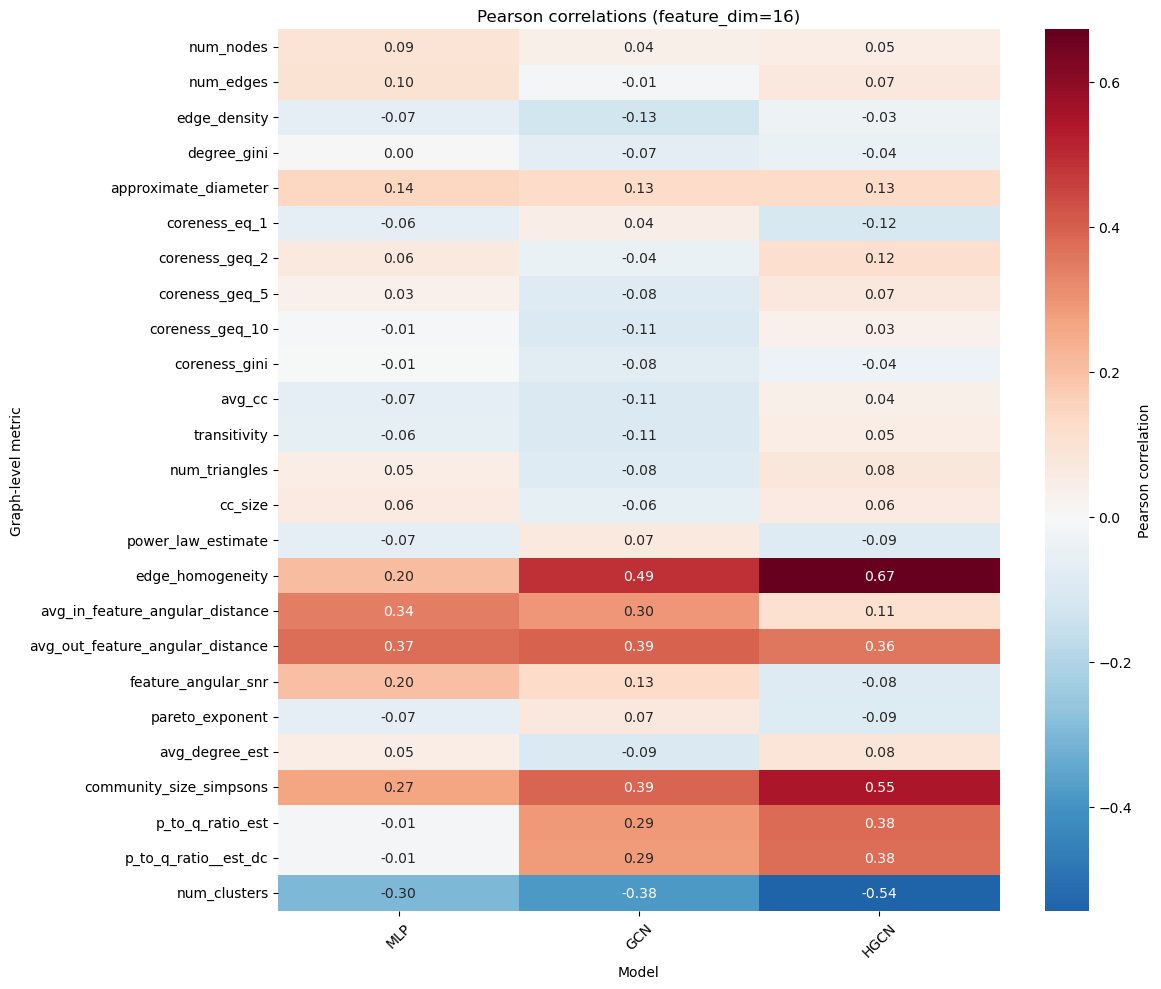

In [208]:
graph_metrics = [
    "num_nodes", "num_edges", "edge_density",
    "degree_gini", "approximate_diameter", "coreness_eq_1",
    "coreness_geq_2", "coreness_geq_5", "coreness_geq_10", "coreness_gini",
    "avg_cc", "transitivity", "num_triangles", "cc_size",
    "power_law_estimate", "edge_homogeneity",
    "avg_in_feature_angular_distance", "avg_out_feature_angular_distance",
    "feature_angular_snr", "pareto_exponent", "avg_degree_est",
    "community_size_simpsons", "p_to_q_ratio_est", "p_to_q_ratio__est_dc", 'num_clusters'
]

models = ["MLP", "GCN", "HGCN"]

corr_df = compute_and_plot_graph_metric_correlations(
    df=combined_df,
    feature_dim=16,
    graph_metrics=graph_metrics,
    models=models,
    perf_suffix="test_f1_macro",
    corr_method="pearson",      # or "spearman"
    figsize=(12, 10)
)


What we observe: both GCN models benefit from edge homogeniety. This makes sense, since they rely on the assumption that similarly classed nodes are connected in the graph. It is particularly strong for the HGCN, with an r-value of .67. All models have a moderate correlation with avg_out_feature_angular_distance, which measures the average angular similarity between the node-features of differingly classed nodes. Thus, when this distance is larger, it is easier to discriminate from the node-features the class, and all models do better. There is a monotonic response to community_size_simpsons, where MLP has a small to moderate correlation, the GCN moderate and the HGCN moderate to high. This metric measures the class size imbalances in a graph, with a large value signifying very unbalanced classes. This implies then that the HGCN performs better when there is a large class size discrepancy.  

One of the primary things we are interested in saying something about is given a graph, what model type should be used. To answer this, we fit a random forest model where the independent variables are the graph metrics (to make the picture clearer, if no model has r>.15 with a metric we discard it) above, and the dependent variables are MLP and GCN performance, wrt f1-macro.

In [211]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score

# 1) Load your combined DataFrame and restrict to feature_dim = 16
df = combined_df.copy()
df16 = df[df["feature_dim"] == 16].reset_index(drop=True)

# 2) Identify “eligible” graph‐metrics whose Pearson |r| > 0.15 with MLP or GCN test‐F1

# (a) list of all graph‐metric column names
graph_metrics = [
    "num_nodes", "num_edges", "edge_density", "degree_gini", "approximate_diameter",
    "coreness_eq_1", "coreness_geq_2", "coreness_geq_5", "coreness_geq_10",
    "coreness_gini", "avg_cc", "transitivity", "num_triangles", "cc_size",
    "power_law_estimate", "edge_homogeneity", "avg_in_feature_angular_distance",
    "avg_out_feature_angular_distance", "feature_angular_snr", "pareto_exponent",
    "avg_degree_est", "community_size_simpsons", "p_to_q_ratio_est",
    "p_to_q_ratio__est_dc"
]

# (b) performance columns for MLP and GCN
perf_cols = {
    "MLP": "MLP__test_f1_macro",
    "GCN": "GCN__test_f1_macro"
}

eligible_metrics = set()
for metric in graph_metrics:
    if metric not in df16.columns:
        continue

    # drop any rows where either metric or perf is not finite
    sub = df16[[metric, perf_cols["MLP"], perf_cols["GCN"]]].dropna()
    x = sub[metric].values
    
    # MLP
    y_m = sub[perf_cols["MLP"]].values
    finite_mask_m = np.isfinite(x) & np.isfinite(y_m)
    if finite_mask_m.sum() >= 3:
        r_m, _ = pearsonr(x[finite_mask_m], y_m[finite_mask_m])
    else:
        r_m = 0.0

    # GCN
    y_g = sub[perf_cols["GCN"]].values
    finite_mask_g = np.isfinite(x) & np.isfinite(y_g)
    if finite_mask_g.sum() >= 3:
        r_g, _ = pearsonr(x[finite_mask_g], y_g[finite_mask_g])
    else:
        r_g = 0.0

    if abs(r_m) > 0.15 or abs(r_g) > 0.15:
        eligible_metrics.add(metric)

eligible_metrics = sorted(eligible_metrics)
print(f"Eligible graph‐metrics (|r| > 0.15):\n{eligible_metrics}\n")

# 3) Build a “label” column: 1 if GCN wins, 0 if MLP wins (drop ties)
df16["best_model"] = np.where(
    df16[perf_cols["GCN"]] > df16[perf_cols["MLP"]], "GCN", "MLP"
)
# drop rows where they tie exactly or where either is NaN
df16 = df16.dropna(subset=[perf_cols["MLP"], perf_cols["GCN"]])
df16 = df16[df16[perf_cols["GCN"]] != df16[perf_cols["MLP"]]].reset_index(drop=True)

# 4) Prepare the feature matrix X and target y
X = df16[eligible_metrics].copy()
y = df16["best_model"].map({"MLP": 0, "GCN": 1}).values

# (Optionally) Impute any remaining infinities or large outliers—here we simply fill infinities with column median
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape)

# 6) Fit a Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 7) Evaluate on the held‐out test set
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy (MLP vs GCN): {acc:.3f}\n")
print(classification_report(y_test, y_pred, target_names=["MLP","GCN"]))

# 8) Optional: 5‐fold cross‐validation accuracy
cv_scores = cross_val_score(rf, X, y, cv=5, scoring="accuracy", n_jobs=-1)
print(f"5‐fold CV accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# 9) Examine feature importances
importances = pd.Series(rf.feature_importances_, index=eligible_metrics)
importances = importances.sort_values(ascending=False)
print("\nFeature importances (most→least):")
print(importances.head(10))


Eligible graph‐metrics (|r| > 0.15):
['avg_in_feature_angular_distance', 'avg_out_feature_angular_distance', 'community_size_simpsons', 'edge_homogeneity', 'feature_angular_snr', 'p_to_q_ratio__est_dc', 'p_to_q_ratio_est']

(392, 7)
Test accuracy (MLP vs GCN): 0.616

              precision    recall  f1-score   support

         MLP       0.63      0.79      0.70        57
         GCN       0.57      0.38      0.46        42

    accuracy                           0.62        99
   macro avg       0.60      0.59      0.58        99
weighted avg       0.61      0.62      0.60        99

5‐fold CV accuracy: 0.578 ± 0.037

Feature importances (most→least):
p_to_q_ratio__est_dc                0.171111
edge_homogeneity                    0.155876
p_to_q_ratio_est                    0.152864
avg_out_feature_angular_distance    0.135348
feature_angular_snr                 0.130778
community_size_simpsons             0.128397
avg_in_feature_angular_distance     0.125627
dtype: float64


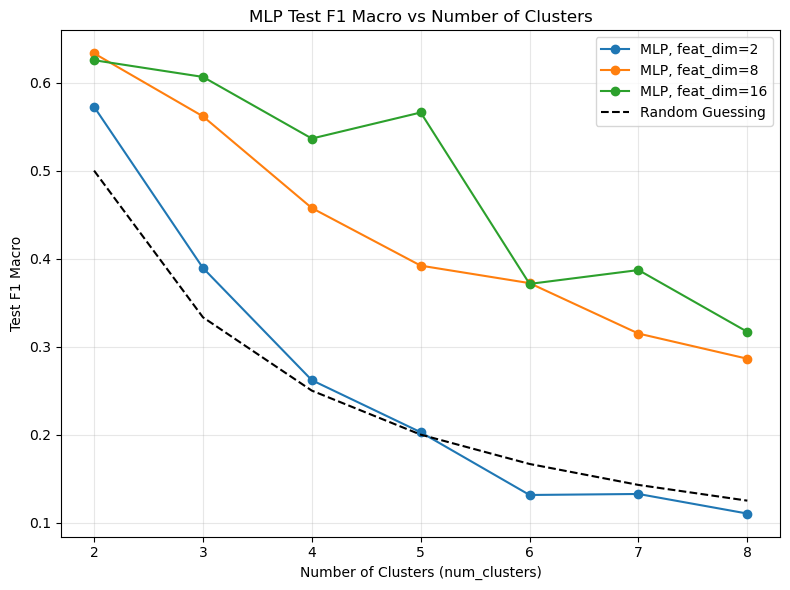

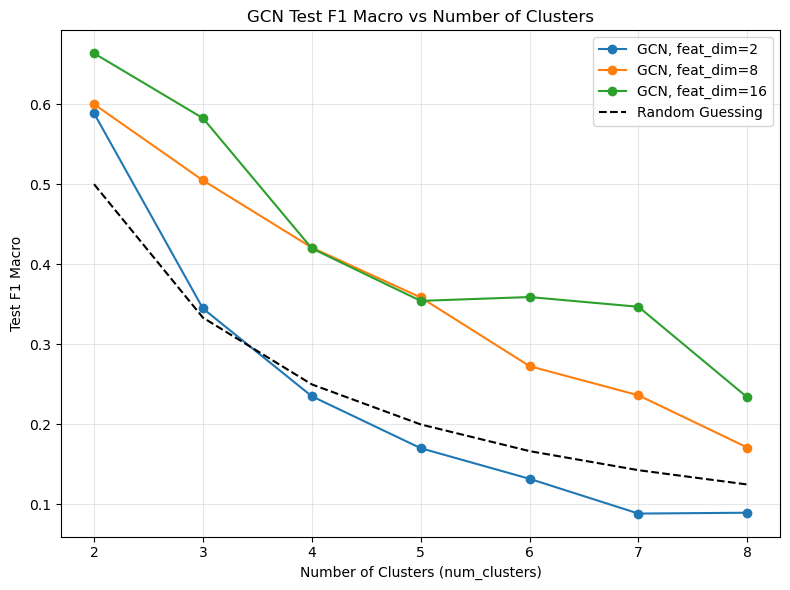

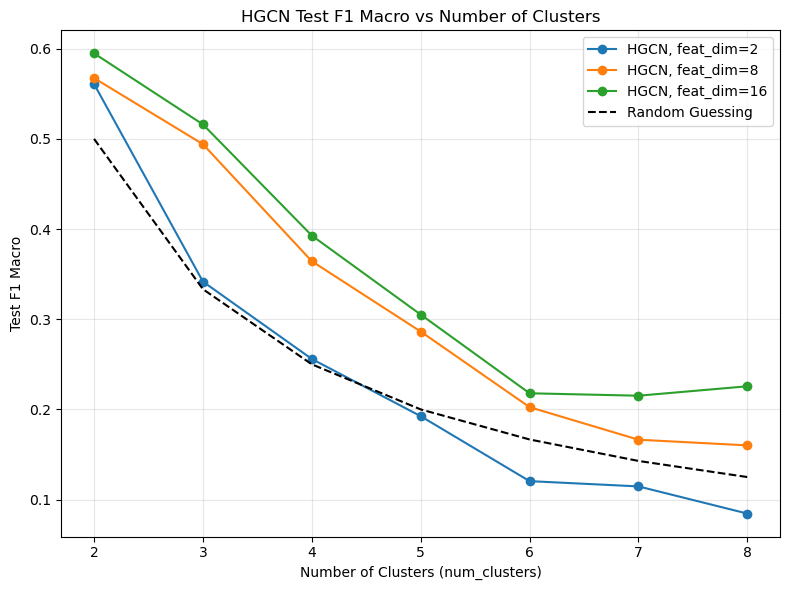

In [70]:
models = ['MLP', 'GCN', 'HGCN']
metric = 'test_f1_macro'
for model in models:
    plot_performance_vs_clusters(combined_df, model, metric)

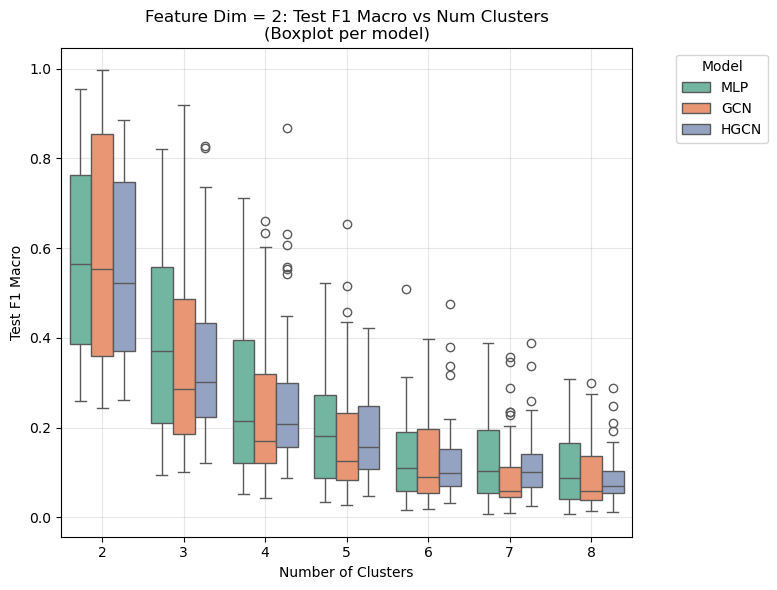

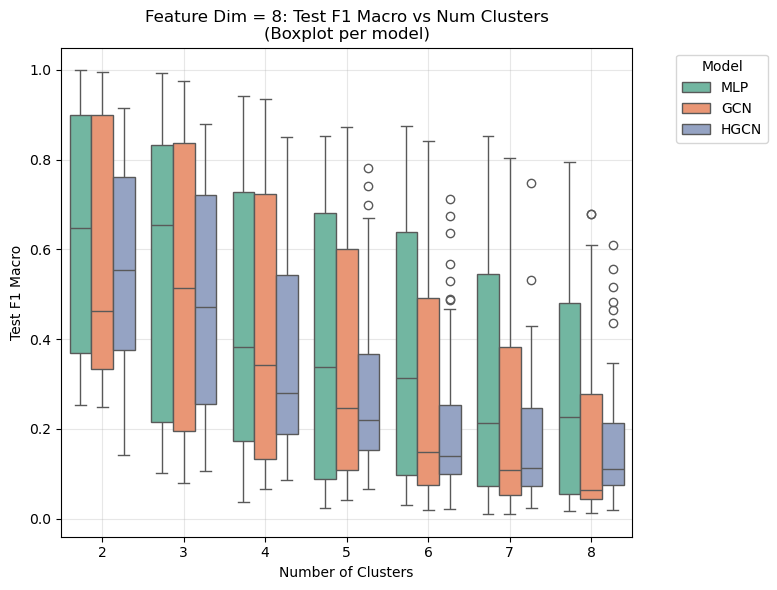

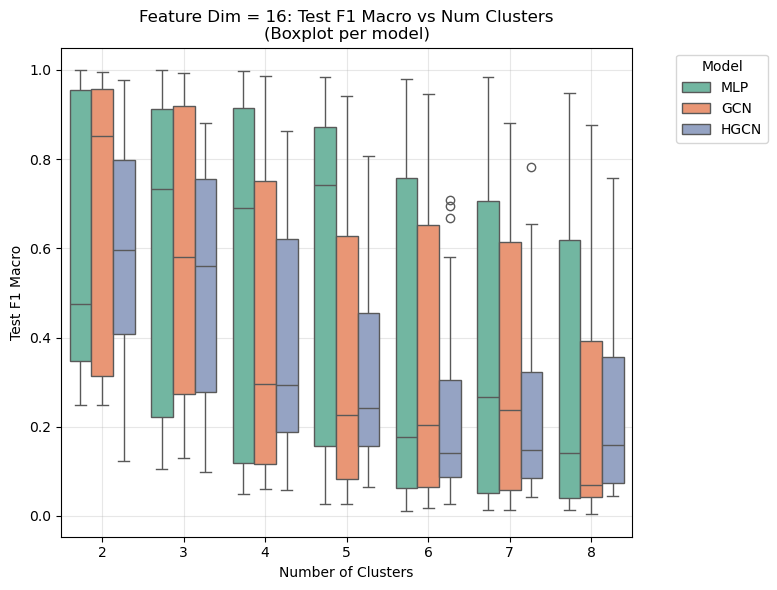

In [90]:
for dim in [2, 8, 16]:
    boxplot_models_vs_clusters_for_dim(combined_df, feature_dim=dim, models = models, metric = 'test_f1_macro')

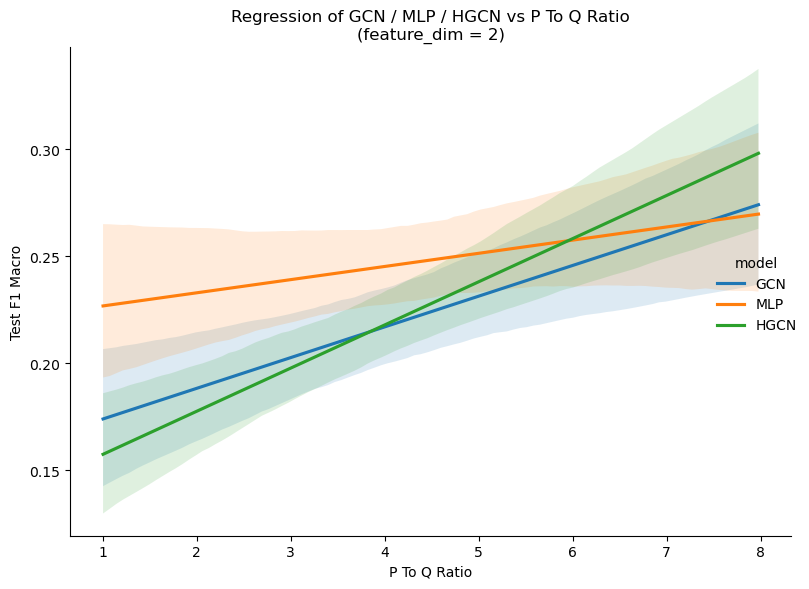

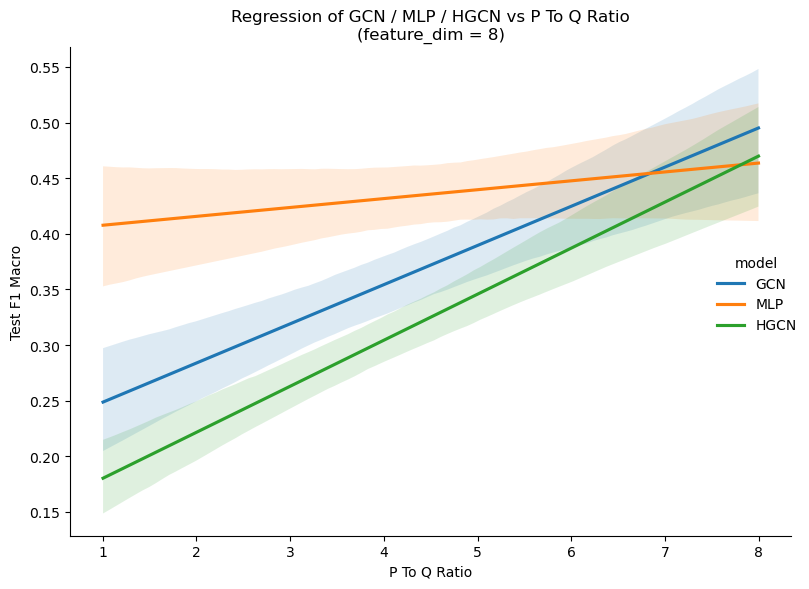

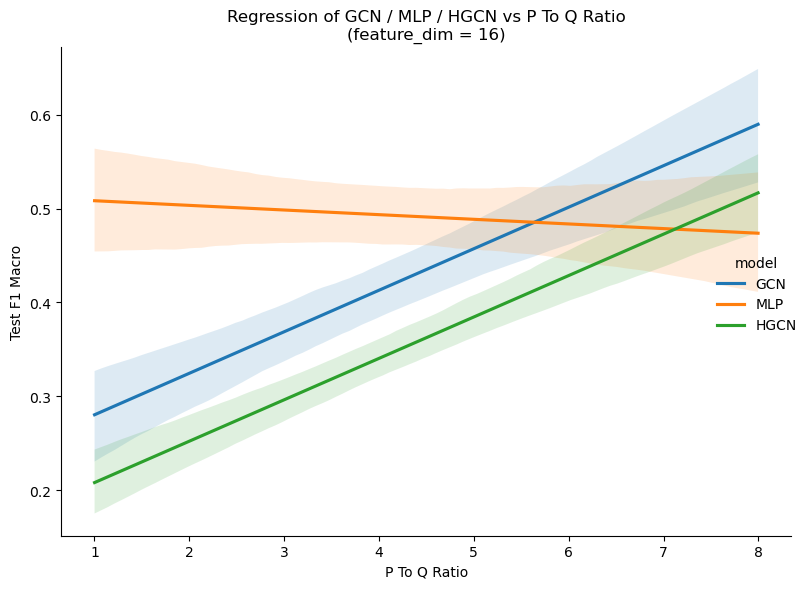

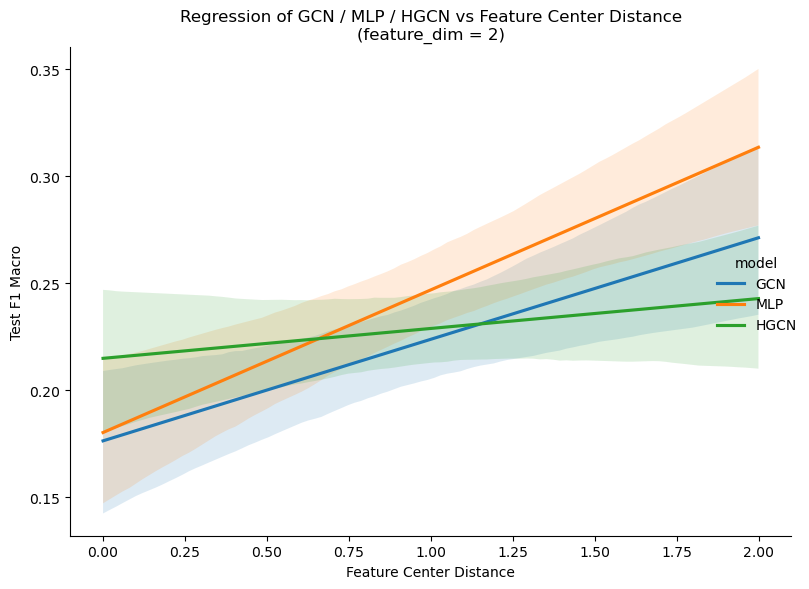

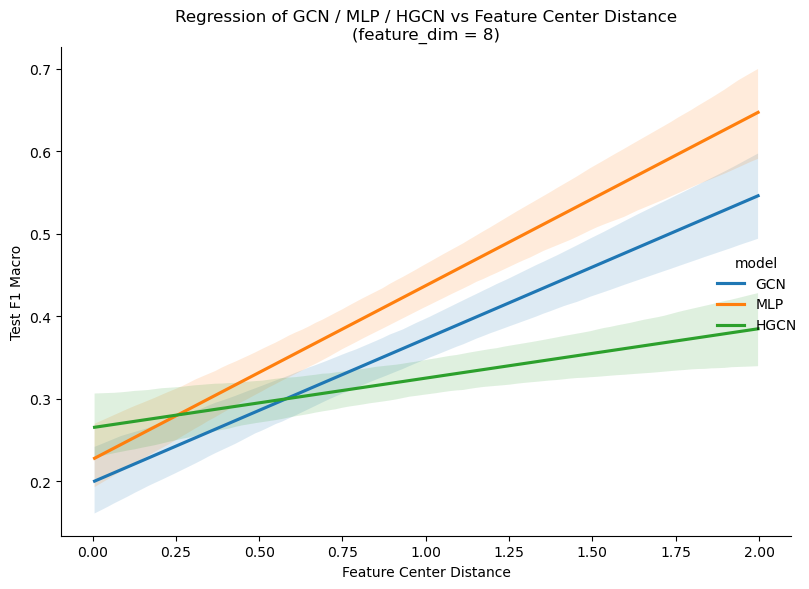

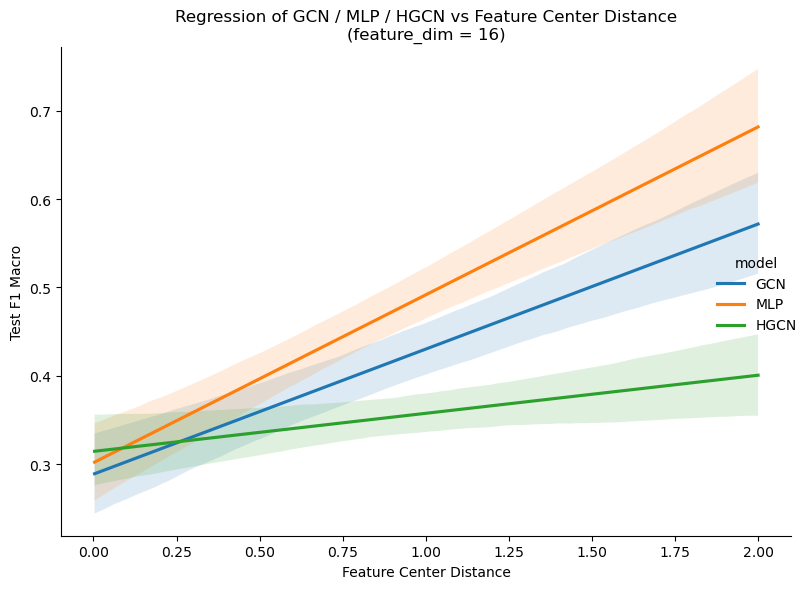

In [92]:
from itertools import product

for gen_param, dim in product(['p_to_q_ratio', 'feature_center_distance'], [2, 8, 16]):
    plot_all_models_regression_for_dim(combined_df=combined_df, feature_dim = dim, metric= metric, x_col = gen_param)

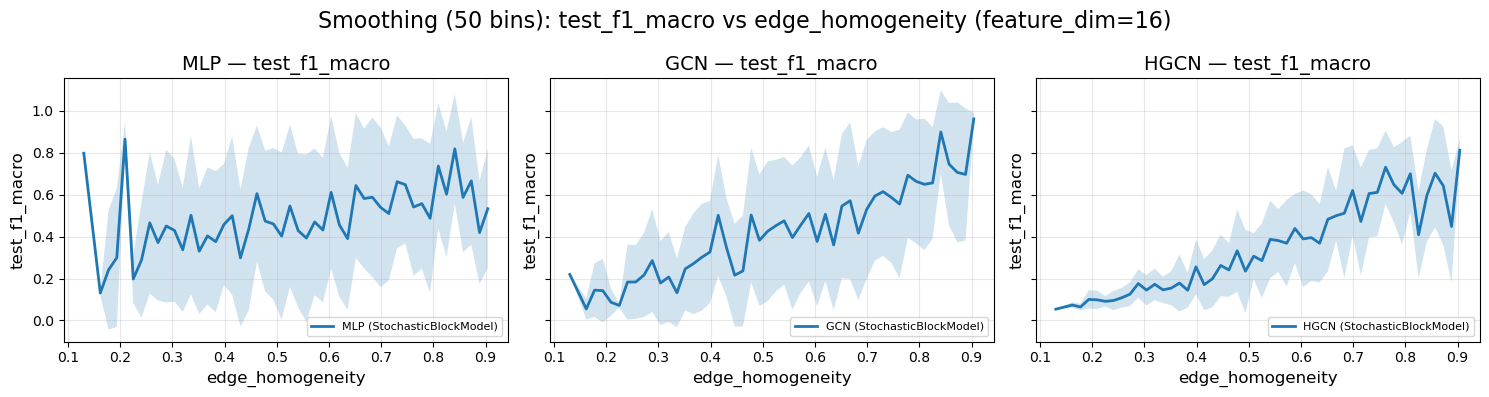

In [224]:
models = ["MLP", "GCN", "HGCN"]
metric = "edge_homogeneity"
perf_meas = "test_f1_macro"
feature_dim = 16

smooth_binning_plots(
    df=combined_df,
    models=models,
    perf_meas=perf_meas,
    metric=metric,
    feature_dim=feature_dim,
    num_bins=50
)

In [236]:
import os, sys

# 1. Compute the src/ directory (one level up from notebooks/)
notebooks_dir = os.getcwd()                            # e.g. …/graphworld/src/notebooks
src_dir       = os.path.abspath(os.path.join(notebooks_dir, os.pardir))
# 2. Prepend it to Python’s module search path
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

## Also look at new dataset where sample complexity is varied!

In [9]:
RESULTS_DIR = '../../graph_gen/snellius_gen/label_efficiency/2/'
df = df_gen(RESULTS_DIR, NSHARDS=NSHARDS) 

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [11]:
df['num_train_per_class'].value_counts()

num_train_per_class
4     107
8     103
2     102
16     99
1      89
Name: count, dtype: int64

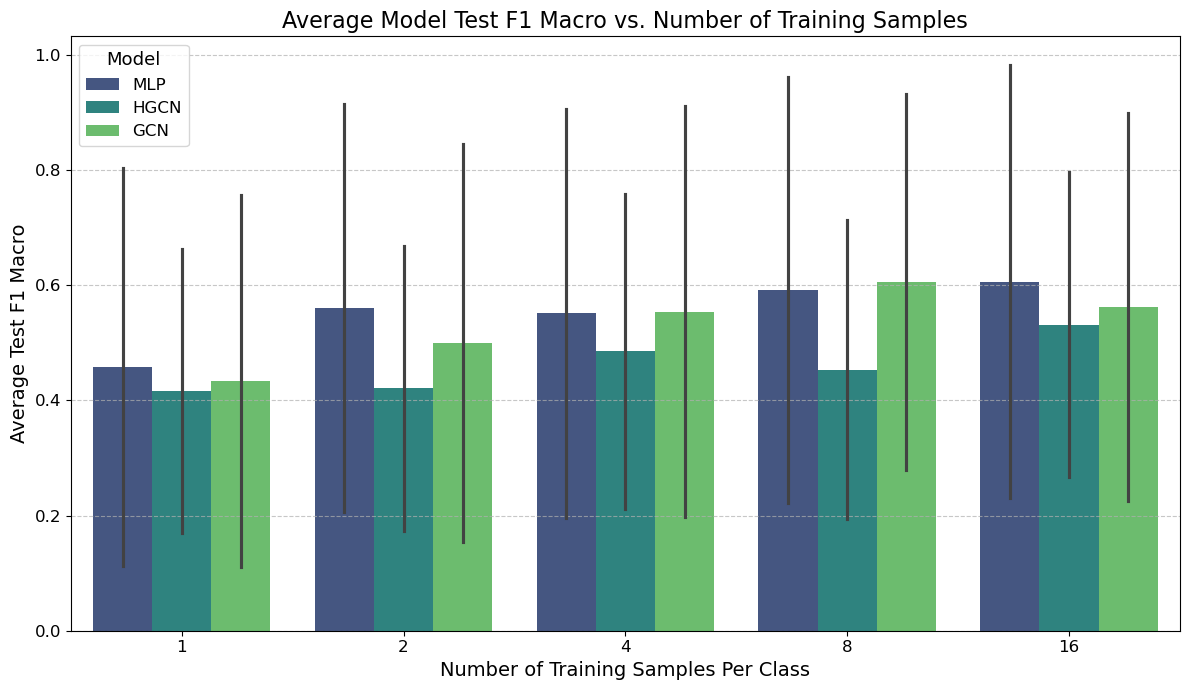

Plot showing average Test F1 Macro for GCN, MLP, and HGCN models across different 'num_train_per_class' values.
Error bars represent the standard deviation of performance for each model at each training sample size.


In [13]:
PERFORMANCE_METRIC = 'test_f1_macro'

# Define the models you are interested in.
MODELS = ['GCN', 'MLP', 'HGCN']

# --- Data Preparation ---
# Create a list of columns to select for plotting.
columns_to_select = ['num_train_per_class']
for model in MODELS:
    columns_to_select.append(f'{model}__{PERFORMANCE_METRIC}')

# Select only the relevant columns from the DataFrame.
plot_df = df[columns_to_select].copy()

# Rename the performance columns for easier plotting (remove model prefix).
# This creates columns like 'GCN', 'MLP', 'HGCN' with their performance values.
for model in MODELS:
    plot_df.rename(columns={f'{model}__{PERFORMANCE_METRIC}': model}, inplace=True)

# Melt the DataFrame to long format for easier plotting with seaborn.
# This creates 'model' and 'performance' columns.
melted_df = plot_df.melt(
    id_vars=['num_train_per_class'],
    value_vars=MODELS,
    var_name='Model',
    value_name='Performance'
)

# Sort by 'num_train_per_class' for better visualization order.
melted_df = melted_df.sort_values(by='num_train_per_class')

# --- Plotting ---
plt.figure(figsize=(12, 7))

sns.barplot(
    data=melted_df,
    x='num_train_per_class',
    y='Performance',
    hue='Model',
    errorbar='sd', # Show standard deviation as error bars
    palette='viridis' # Choose a color palette
)

plt.title(f'Average Model {PERFORMANCE_METRIC.replace("_", " ").title()} vs. Number of Training Samples', fontsize=16)
plt.xlabel('Number of Training Samples Per Class', fontsize=14)
plt.ylabel(f'Average {PERFORMANCE_METRIC.replace("_", " ").title()}', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Model', fontsize=12, title_fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print(f"Plot showing average {PERFORMANCE_METRIC.replace('_', ' ').title()} for GCN, MLP, and HGCN models across different 'num_train_per_class' values.")
print("Error bars represent the standard deviation of performance for each model at each training sample size.")

These results are interesting, and suggest a few things:
1. The performance floor for low sample complexity is higher perhaps than expected: between 1 and 16 labelled train samples per class, we see an average performance increase of less than 20%. 
2. At 8 training samples per class, the average GCN performance is superior to that of the MLP.
3. The performance of the HGCN is closest to that of the GCN for high sample complexity. We have already observed that the HGCN is poorly suited - in comparison to the other models - for this manner of graph task, with this structure of feature space. It's likely that the abundance of samples helps it overcome the modelling difficults experienced with fewer samples. 

## Hierarchical features

In [203]:
RESULTS_DIR1 = '../../graph_gen/snellius_gen/hier_feats/1'
RESULTS_DIR2 = '../../graph_gen/snellius_gen/hier_feats/2'
RESULTS_DIR3 = '../../graph_gen/snellius_gen/hier_feats/3'

df1 = df_gen(RESULTS_DIR1, NSHARDS=NSHARDS) 
df2 = df_gen(RESULTS_DIR2, NSHARDS)
df3 = df_gen(RESULTS_DIR3, NSHARDS)

df = pd.concat([df1, df2, df3], axis = 0)
df = df.reset_index(drop=True)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [204]:
df

,nvertex,avg_degree,feature_center_distance,feature_dim,edge_center_distance,edge_feature_dim,p_to_q_ratio,num_clusters,cluster_size_slope,power_exponent,...,HGCN__model_c,HGCN__model_dropout,HGCN__model_hidden_channels,HGCN__model_in_channels,HGCN__model_lr,HGCN__model_num_layers,HGCN__model_weight_decay,HGCN__model_out_channels,HGCN__train_epochs,HGCN__train_patience
0,700,5.574830,4.375600,16,1.0,1,5.282920,3,0.714985,0.224290,...,NaN,0.0,32,16,0.0010,1,0.0010,3,200,10
1,358,8.576159,5.153496,16,1.0,1,1.978585,5,0.792415,0.671956,...,2.0,0.2,32,16,0.0020,2,0.0000,5,200,10
2,352,8.962458,5.430295,16,1.0,1,3.068298,5,0.667786,0.801894,...,NaN,0.0,8,16,0.0020,1,0.0005,5,200,10
3,407,5.570200,5.657363,16,1.0,1,1.340580,6,0.252084,0.270973,...,1.0,0.6,32,16,0.0010,2,0.0000,6,200,10
4,243,7.878172,5.744525,16,1.0,1,3.090394,5,0.165354,0.873801,...,1.0,0.0,8,16,0.0020,2,0.0000,5,200,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,153,9.418440,4.439744,16,1.0,1,3.791406,6,0.511295,0.446111,...,1.0,0.2,32,16,0.0010,2,0.0010,6,200,10
2246,494,6.536709,5.229092,16,1.0,1,6.553367,6,0.732604,0.621490,...,1.0,0.0,32,16,0.0005,2,0.0005,6,200,10
2247,802,9.408320,4.760836,16,1.0,1,3.302446,7,0.146774,0.641702,...,1.0,0.0,16,16,0.0020,2,0.0000,7,200,10
2248,297,7.843137,4.326658,16,1.0,1,2.888585,5,0.925225,0.424716,...,0.5,0.0,16,16,0.0020,2,0.0001,5,200,10


In [205]:
df['super_group_method'].value_counts()

super_group_method
half         756
sqrt_ceil    748
binary       746
Name: count, dtype: int64

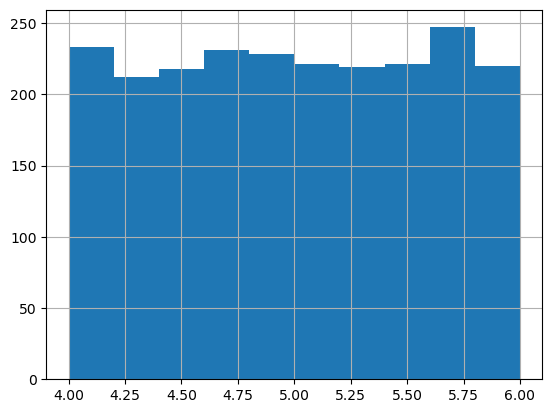

In [195]:
df['feature_center_distance'].hist()
plt.show()

In [196]:
df['feat_hier_score'].std()

20.00147708835245

Proportion of runs where HGCN was the best model by regime:
super_group_method
binary       0.201072
half         0.181217
sqrt_ceil    0.203209
Name: best_model, dtype: float64

Overall correlation between feature hierarchy score and HGCN advantage: -0.024

Correlation by regime:
super_group_method
binary      -0.050930
half         0.083444
sqrt_ceil    0.063753
dtype: float64


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_52725/3296456812.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_per_regime = df.groupby('super_group_method').apply(


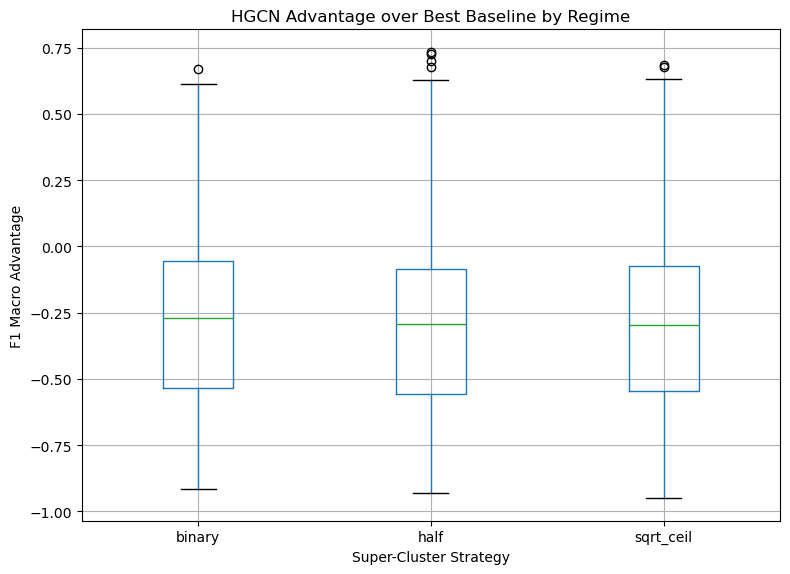

In [197]:
# Ensure the regime column exists; if it's named differently, adjust accordingly
# Here we assume generator_config.super_group_method was saved as 'super_group_method'
if 'super_group_method' not in df.columns and 'super_group_strat' in df.columns:
    df['super_group_method'] = df['super_group_strat'].map({0: 'binary', 1: 'half', 2: 'sqrt_ceil'})

# 1) For each regime, compute the proportion of runs where HGCN is best
models = ['GCN__test_f1_macro', 'MLP__test_f1_macro', 'HGCN__test_f1_macro']
df['best_model'] = df[models].idxmax(axis=1).str.replace('__test_f1_macro', '')
prop_hgcn_best = df.groupby('super_group_method')['best_model'].apply(lambda x: (x == 'HGCN').mean())
print("Proportion of runs where HGCN was the best model by regime:")
print(prop_hgcn_best)

# 2) Compute HGCN advantage over the best baseline
df['best_baseline_f1'] = df[['GCN__test_f1_macro', 'MLP__test_f1_macro']].max(axis=1)
df['hgcn_advantage'] = df['HGCN__test_f1_macro'] - df['best_baseline_f1']

# 3) Correlation between feature hierarchy score and HGCN advantage
corr_overall = df[['feat_hier_score', 'hgcn_advantage']].corr().loc['feat_hier_score', 'hgcn_advantage']
print(f"\nOverall correlation between feature hierarchy score and HGCN advantage: {corr_overall:.3f}")

# Per-regime correlations
corr_per_regime = df.groupby('super_group_method').apply(
    lambda sub: sub[['feat_hier_score', 'hgcn_advantage']].corr().loc['feat_hier_score', 'hgcn_advantage']
)
print("\nCorrelation by regime:")
print(corr_per_regime)

# 4) Boxplot of HGCN advantage per regime
fig, ax = plt.subplots(figsize=(8, 6))
df.boxplot(column='hgcn_advantage', by='super_group_method', ax=ax)
ax.set_title('HGCN Advantage over Best Baseline by Regime')
ax.set_xlabel('Super-Cluster Strategy')
ax.set_ylabel('F1 Macro Advantage')
plt.suptitle('')  # remove automatic title
plt.tight_layout()
plt.show()


half


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_52725/3913933691.py:487: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_52725/3913933691.py:499: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_52725/3913933691.py:499: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ve

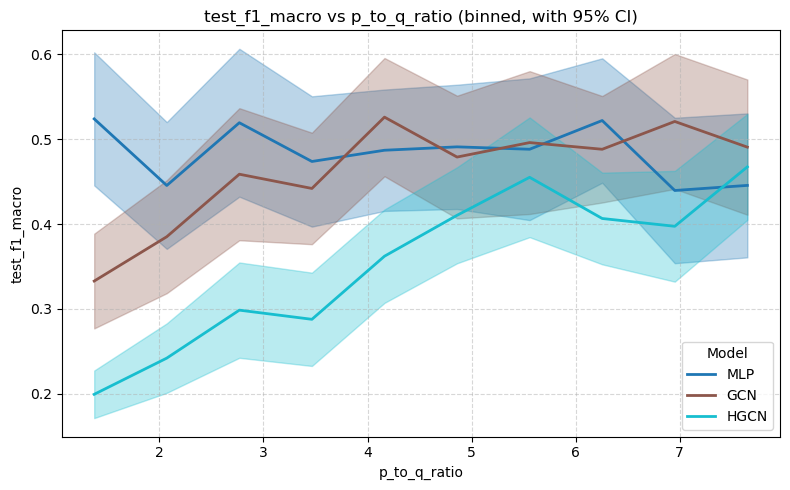

binary


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_52725/3913933691.py:527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_52725/3913933691.py:487: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_52725/3913933691.py:499: FutureWarning: The default of observed=False is deprecated and will be changed to True in a futu

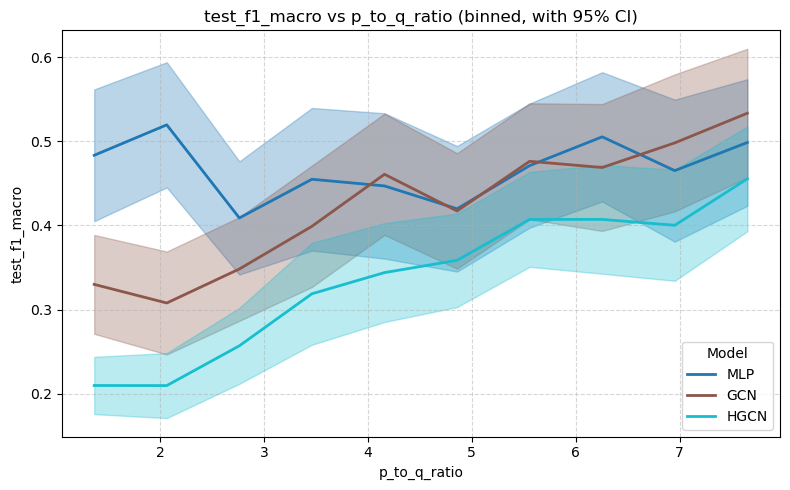

sqrt_ceil


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_52725/3913933691.py:527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_52725/3913933691.py:487: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_52725/3913933691.py:499: FutureWarning: The default of observed=False is deprecated and will be changed to True in a futu

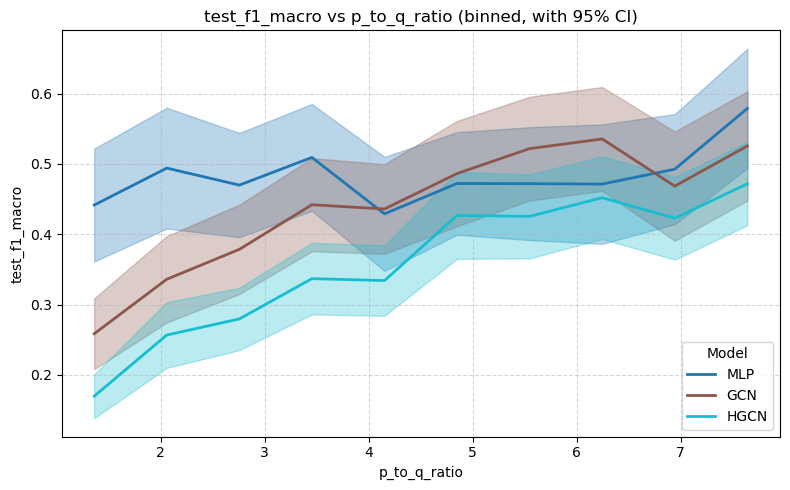

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_52725/3913933691.py:527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)


In [209]:
hier_feat_strat = ['half', 'binary', 'sqrt_ceil']

for method in hier_feat_strat:
    print(method)
    smoothed_plot_perf_vs_metric(
        df=df[df['super_group_method'] == method],
        models = ['MLP', 'GCN', 'HGCN'],
        perf_meas='test_f1_macro',
        metric='p_to_q_ratio'
    )

## Generated using the random match type in the sbm_simulator for feature_membership attribution in the graphworld package

In [141]:
RESULTS_DIR = '../../graph_gen/snellius_gen/random_feats/random_feats/'
RESULTS_DIR1 = '../../graph_gen/snellius_gen/random_feats/random_feats2/'

df1 = df_gen(RESULTS_DIR, NSHARDS=NSHARDS) 
df2= df_gen(RESULTS_DIR1, NSHARDS=NSHARDS)
models = ['MLP', 'GCN', 'HGCN']

df = pd.concat([df1, df2])
df = df.reset_index(drop = True)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


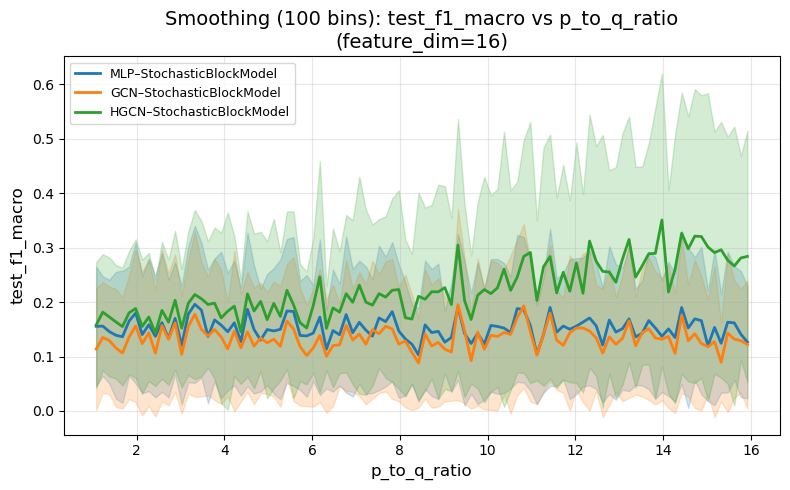

In [154]:
smooth_binning_plot(df, ['MLP', 'GCN', 'HGCN'], perf_meas='test_f1_macro', metric = 'p_to_q_ratio', feature_dim=16, num_bins = 100)

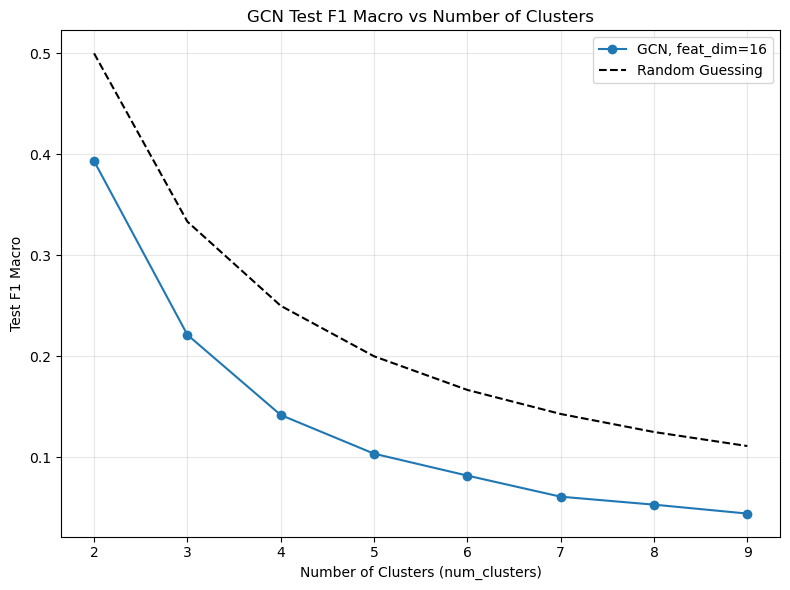

In [148]:
plot_performance_vs_clusters(df, model = 'GCN', metric = 'test_f1_macro')